### Resolução de ODEs com Chebyshev

#### matriz de diferenciação
Dado um conjunto de pontos $(u_0,u_1,\cdots,u_N)$, podemos fazer uma interpolação:

$$
p(x) = \sum_{j=0}^N u_j \frac{\prod_{k\neq j}\;(x-x_k)}{\prod_{k\neq j}\;(x_j-x_k)}.
$$

Então a derivada  pode ser calculada nos pontos da grelha como:

$ p'(x) \rightarrow p'(x_j) \rightarrow D_{ij} =
 \left\{\begin{array}{lr}
        \frac{a_i}{a_j(x_i-x_j)}, & i\neq j\\
        \sum_{k\neq j}\frac{1}{(x_i-x_j)}, & i = j
        \end{array}\right. 
        $
        
onde $a_j =\prod_{k\neq j}\;(x_j-x_k)$


Então para os polinómios de Chebyshev, com os pontos de colocação de gauss-Lobato vistos antes ($x_j = \cos(j\pi/N)\;\; j=0,\cdots, N)$, teremos a matriz de diferenciação:

$
D_N = 
\left[ \begin{array}{@{}c|c|c@{}}
   \frac{2N^2+1}{6} & 2\frac{(-1)^j}{1-x_j} & \frac{1}{2}(-1)^N \\
   \hline
   \frac{1}{2}\frac{(-1)^i}{1-x_i} & \begin{matrix}
                  &                   & \frac{(-1)^{i+j}}{x_i-x_j} \\
                  &   \frac{-x_j}{2(1-x^2_j)}   &     \\
         \frac{(-1)^{i+j}}{x_i-x_j}  &          &    
           \end{matrix} 
      & \frac{1}{2}\frac{(-1)^{N+i}}{1+x_i}   \\
   \hline
   -\frac{1}{2}(-1)^N  & -2\frac{(-1)^j}{1+x_j}  & \frac{2N^2+1}{6} \\
\end{array} \right]
$

Assim $\vec{w} = D_N \cdot u(\vec{x})\approx u'(\vec{x})$ com precisão espectral, $\vec{w} = D^2_N \cdot u(\vec{x})\approx u''(\vec{x})$ com precisão espectral, etc.

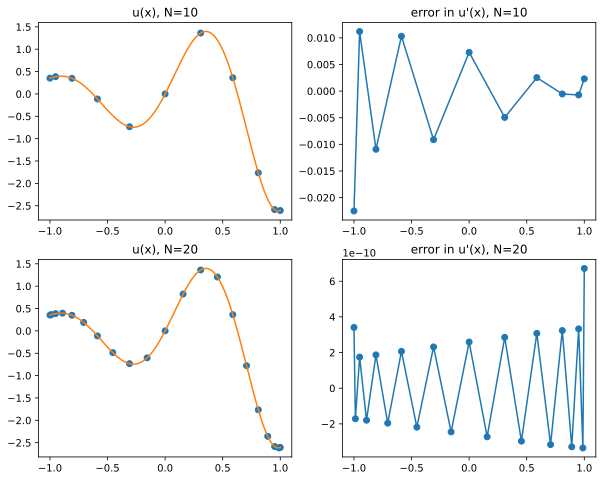

In [7]:
''' p11.m  Trefethen'''''
%matplotlib inline
%config InlineBackend.figure_format='svg'
from numpy import linspace,exp,sin,dot
from matplotlib.pyplot import figure,subplot,plot,title
from cheb import *

xx = linspace(-1.0,1.0,200,True)
uu = exp(xx)*sin(5.0*xx)
c = 1; figure(figsize=(10,8))
for N in [10,20]:
    D,x = cheb(N); u = exp(x)*sin(5.0*x)
    subplot(2,2,c); c += 1
    plot(x,u,'o',xx,uu)
    title('u(x), N='+str(N))
    
    error = dot(D,u) - exp(x)*(sin(5.0*x)+5.0*cos(5.0*x))
    subplot(2,2,c); c += 1
    plot(x,error,'o-')
    title('error in u\'(x), N='+str(N))

### Diferenciação via FFT
#### Motivação
Existe uma equivalência entre:
\begin{align*}
\mbox{série de Chebyshev     }\;\;\;\; & x \in [-1,1] \\
\mbox{série de Fourier       } \;\;\;\;&  \theta \in \mathbb{R} \\
\mbox{série de Laurent       }\;\;\;\; &  z \;\;\mbox{no círculo unitário}
\end{align*}

Temos as relações:

$$ x= Re(z) = \frac{1}{2}(z+z^{-1} ) = \cos \theta \in [-1,1] $$

pelo que o polinómio de Chebyshev de grau $n$ é:

$$
T_n(x)= Re(z^n) = \frac{1}{2}(z^n+z^{-n} ) = \cos n\theta
$$

Como $T_n(x)$ é exactamente de grau $n$ para cada $n$, um polinómio de grau $N$ pode ser escrito univocamente como uma combinação linear  de polinómios de Chebyshev:

$$
p(x) = \sum_{n=0}^{N} a_n T_n(x)\;\;\;\;  x \in [-1,1].
$$

Correspondente a este, existe um polinómio de Laurent  de grau $N$  em  $z$ e $z^{-1}$ que é auto-recíproco (ié, coeficientes de $z^n$ e $z^{-n}$ são iguais):

$$
\mathbf{p}(z) = \frac{1}{2}\sum_{n=0}^{N} a_n (z^n+z^{-n} )\;\;\;\;  |z|=1.
$$

E a $p(x)$ corresponde ainda um polinómio trigonométrico periódico (de período $2\pi$ de grau $N$:

$$
    P(\theta) = \sum_{n=0}^{N} a_n \cos n\theta\;\;\;\;  \theta \in \mathbb{R}.
$$

São equivalentes no sentido que $p(x) = \mathbf{p}(z) = P(\theta)$ quando $x,z,\theta$ estão relacionados por (1).

De um modo análogo, para uma função arbitrária  $f(x)$ definida em $[-1,1]$ podemos construir uma função auto-recíproca $\mathbf{f}(z)$ definida no círculo unitário, e uma função periódica $F(\theta)$ definida em $\mathbb{R}$ por:

$$ 
\mathbf{f}(z) = f\bigg( \frac{z+z^{-1}}{2}\bigg), \;\;\;\;\;\; F(\theta) = f(\cos\theta)
$$

Os pontos de interpolação são, respectivamente:

$$\theta_j = j\pi/N\;\;\;\; z_j = e^{i\theta_j}\;\;\;\;x_j = \cos\theta_j = Re(z_j),
$$

e $P(\theta)$ interpola $F(\theta)$ (par e periódica)  nos pontos equidistantes $\{\theta_j\}$; $\mathbf{p}(z)$ interpola  $\mathbf{f}(z)$ nas raízes da unidade $\{z_j\}$; e $p(x)$ interpola $f(x)$  nos pontos (raízes) de Chebyshev $\{x_j\}$.

#### Algoritmo
A diferenciação de Chebyshev pode também ser alcançada via FFT seguindo o algoritmo (para uma boa explicação, ver Trefethen,_Spectral Methods in Matlab_, cap8):
1. Dados $(u_0,u_1,\ldots,u_N)$ em $x_j = \cos(j\pi/N)$, estendemos o vector para $\vec{U}=(u_0,u_1,\ldots,u_N,u_{N-1},\ldots, u_1)$;
2. Fazemos a FFT de $\vec{U}$ para obter $\hat{U}_k = \frac{\pi}{N} \sum_{j=1}^{2N} e^{-ik\theta_j} U_j$, $k=-N+1,\ldots,N$;
3. $\hat{W}_k = ik\hat{U}_k$, $ \hat{W}_N = 0$ (primeira derivada);
4. Tomamos a FFT inversa: $W_j = \frac{1}{2\pi}\sum_{k=-N+1}^{N}e^{ik\theta_j}\hat{W}_k$, $ j=1,\ldots, 2N$;
5. Então (o apóstrofo indica que os termos $n=0,N$ devem ser  multiplicados por $1/2$):

$$ \left\{\begin{array}{lr}
        w_j = -\frac{W_j}{\sqrt{1-x^2_j}}, & j=1,\ldots, N-1\\
        w_0 = \frac{1}{2\pi}\sum_{n=0}^{N}' n^2\hat{u}_n, & w_N = \frac{1}{2\pi}\sum_{n=0}^{N}' (-1)^{n+1}n^2\hat{u}_n
        \end{array}\right. \notag
$$

Então dada uma função (polinomial) de $x$, $p(x)$, podemos fazer uma mudança de variável $x=\cos \theta$, de modo que se expandirmos $p(x)$ em polinómios de Chebyshev teremos:

$
p(x) = \sum_{n=0}^N\alpha_n T_n(x)$

ou 

$ P(\theta) = \sum_{n=0}^N\alpha_n \cos(n\theta).$


A derivada de $p(x)$ é então obtida de:

\begin{align*}
p'(x) = & \frac{P'(\theta)}{\frac{dx}{d\theta}} = \frac{-\sum_{n=0}^Nn \alpha_n \sin(n\theta)}{-\sin(\theta)}  \\
 = & \frac{-\sum_{n=0}^Nn \alpha_n \sin(n\theta)}{\sqrt{1-x^2}} 
\end{align*}

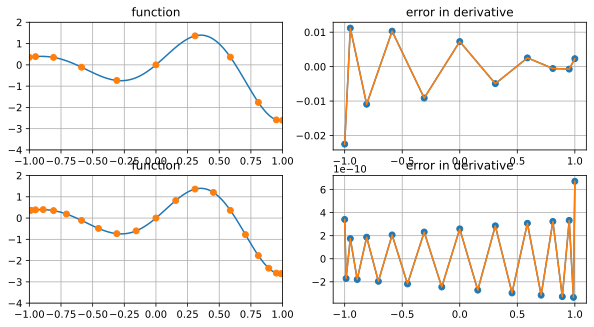

In [8]:
'''p18.m'''''
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from chebfftPy import chebfft
from numpy import pi,linspace,sin,cos,exp,round,zeros,arange,real, flipud
from numpy.fft import fft,ifft
from matplotlib.pyplot import figure,subplot,plot,grid,title,axis

figure(figsize=(10,8))
plot_count = 1

for N in [10,20]:
    xx = linspace(-1.0,1.0,100)
    ff = exp(xx)*sin(5*xx)
    x = cos(arange(0,N+1)*pi/N)
    f = exp(x)*sin(5*x)
    error = chebfft(f) - exp(x)*(sin(5*x)+5*cos(5*x))
    subplot(3,2,plot_count)
    plot_count +=1
    plot(xx,ff,'-',x,f,'o')
    grid(True)
    axis([-1, 1, -4,2])
    title('function')
    subplot(3,2,plot_count)
    plot_count +=1
    plot(x,error,'-o')
    title('error in derivative')
    plot(x,error) 
    grid(True)

### Exemplo 1
**Equação de Poisson**:

$
u_{xx}= e^{4x}
$

no intervalo $]-1,1[$, com condições fronteira de Dirichlet $u(\pm 1)=0$.

Usamos a matriz de diferenciação de Chebyshev, $D_N$, aplicada duas vezes, e removemos os pontos da fronteira:

$$
\left[ \begin{array}{c}
   w_0\\ \hline w_1 \\ \vdots \\ w_{N-1} \\ \hline w_N \end{array} \right]
=
\underbrace{\left[ \begin{array}{@{}c|c|c@{}}
    &   & \\
   \hline
    & \tilde{D}_N^2
      &    \\
   \hline
    &  &  \\
\end{array} \right]}_{{D}_N^2} \cdot
\left[ \begin{array}{c}
   v_0(=0)\\ \hline v_1 \\ \vdots \\ v_{N-1} \\ \hline v_N(=0) \end{array} \right]. \notag
$$

Resolvemos o sistema linear $\tilde{D}_N^2 \cdot \vec{u} = \vec{f}$, onde $\vec{u}= (u_1,\ldots,u_{N-1})$ e $\vec{f} = (e^{4x_1},\ldots,e^{4x_{N-1}}).$

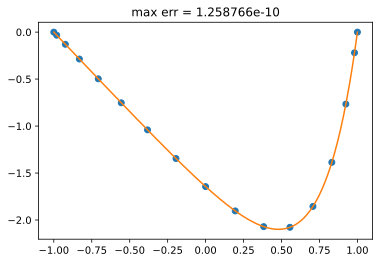

In [9]:
''' Ref.: Trefethen's 'Spectral Methods in MATLAB' book. p13.m
       Code translation by: Praveen Chandrashekar
       (http://cpraveen.github.io/teaching/chebpy.html)
       '''
%matplotlib inline
%config InlineBackend.figure_format='svg'
from cheb import *
from numpy import dot,exp,zeros,sinh,cosh,max,linspace,polyval,polyfit,inf
from numpy.linalg import norm
from scipy.linalg import solve
from matplotlib.pyplot import title,plot

N = 16
D,x = cheb(N)
D2 = dot(D,D)
D2 = D2[1:N,1:N]
f = exp(4.0*x[1:N])
u = solve(D2,f)
s = zeros(N+1)
s[1:N] = u

xx = linspace(-1.0,1.0,200)
uu = polyval(polyfit(x,s,N),xx)    # interpolate grid data
exact = (exp(4.0*xx) - sinh(4.0)*xx - cosh(4.0))/16.0
maxerr = norm(uu-exact,inf)

title('max err = %e' % maxerr)
plot(x,s,'o',xx,exact);

### Exemplo 2
**Equação de Poisson em 2D**:

$
u_{xx} + u_{yy}= f(x,y)
$

no domínio $\Omega=]-1,1[^2$, $f(x,y)=10\sin(8x(y-1))$, com condições fronteira de Dirichlet $\partial \Omega=0$.

Aqui podemos criar uma grelha através do produto dos vectores de cada uma (meshgrid): $(x_i,y_j) = (\cos(i\pi/N),\cos(j\pi/N)).$

Podemos fazer uma abordagem matricial, usando o operador do Python `kron`:

$ L_N = I \bigotimes \tilde{D}_N^2 + \tilde{D}_N^2 \bigotimes I $

Resolvemos o sistema linear $L_N \cdot \vec{u} = \vec{f}.$ (Lembrar que temos que transformar  $\vec{u}$, $\vec{f}$ em vectores)

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from cheb import cheb
from numpy import meshgrid,sin,dot,eye,kron,zeros,reshape,linspace
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure,subplot,plot,title,axis,xlabel,ylabel,spy
from matplotlib import cm
from scipy.linalg import solve
from scipy.interpolate import interp2d

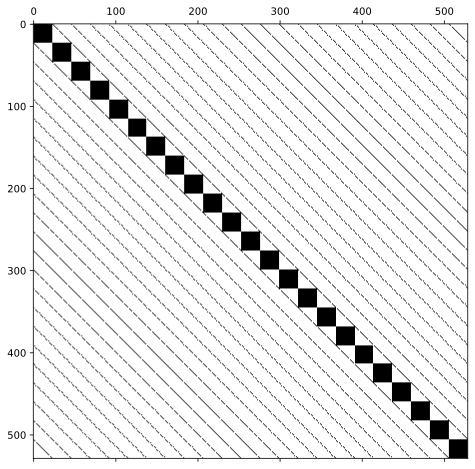

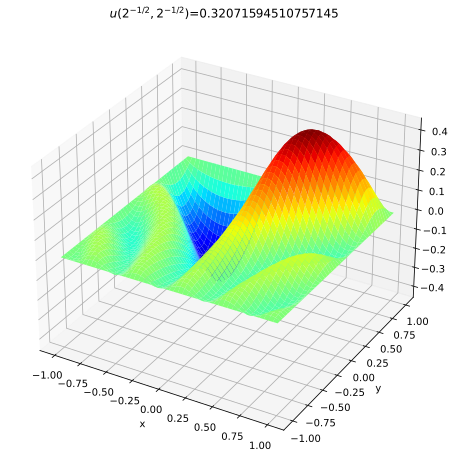

In [6]:
''' Ref.: Trefethen's 'Spectral Methods in MATLAB' book. p16.m
       Code translation by: Praveen Chandrashekar
       (http://cpraveen.github.io/teaching/chebpy.html)
       '''
N = 24; D,x = cheb(N); y = x;
xx,yy = meshgrid(x[1:N],y[1:N])
xx = reshape(xx,(N-1)**2)
yy = reshape(yy,(N-1)**2)
f = 10*sin(8*xx*(yy-1))
D2 = dot(D,D); D2 = D2[1:N,1:N]; I = eye(N-1)
L = kron(I,D2) + kron(D2,I)
# Plot sparsity pattern
figure(figsize=(8,8)), spy(L)
# Solve Lu=f
u = solve(L,f)
# Convert 1-d vectors to 2-d
uu = zeros((N+1,N+1)); uu[1:N,1:N] = reshape(u,(N-1,N-1))
[xx,yy] = meshgrid(x,y)
value = uu[N//4,N//4]

# Interpolate to finer mesh just for visualization
f = interp2d(x,y,uu,kind='cubic')
xxx = linspace(-1.0,1.0,50)
uuu = f(xxx,xxx)
fig = figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = meshgrid(xxx,xxx)
ax.plot_surface(X,Y,uuu,rstride=1,cstride=1,cmap=cm.jet)
title("$u(2^{-1/2},2^{-1/2})$="+str(value))
xlabel("x"); ylabel("y");